In [176]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.tsa.seasonal import STL
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [80]:
dict_stats = {
    'tavg' : 'Average Temperature',
    'tmax' : 'Max Temperature',
    'tmin' : 'Min Temperature',
    'pcp' : 'Precipitation',
    'cdd' : 'Cooling Degree Days',
    'hdd' : 'Heating Degree Days',
    'pdsi' : 'Palmer Drought Severity Index - PDSI',
    'phdi' : 'Palmer Hydrological Drought Index - PHDI',
    'pmdi' : 'Palmer Modified Drought Index - PMDI',
    'zndx' : 'Palmer Z-Index'
}

In [227]:
def read_data(state):
    weather = pd.read_csv(f'collated_data/{state}.csv')
    weather['Date'] = pd.to_datetime(weather['Date'].astype(str), format='%Y%m')
    weather['Date'] = weather['Date'] + pd.offsets.MonthEnd(0)
    weather.set_index('Date', inplace=True)
    weather = weather.asfreq('ME')
    return weather, state

def plot_granger_f_scores(df, col1, col2, max_lag=12, axes=None):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        test_results = grangercausalitytests(df[[col1, col2]], maxlag=max_lag, verbose=False)
        test_results_2 = grangercausalitytests(df[[col2, col1]], maxlag=max_lag, verbose=False)
    lags = []
    f_scores_col1_to_col2 = []
    p_zero_points_col1_to_col2 = []
    f_scores_col2_to_col1 = []
    p_zero_points_col2_to_col1 = []
    
    for lag, result in test_results.items():
        f_score_col1_to_col2 = result[0]['ssr_ftest'][0]
        p_value_col1_to_col2 = result[0]['ssr_ftest'][1]
        f_scores_col1_to_col2.append(f_score_col1_to_col2)
        if p_value_col1_to_col2 < 0.05:
            p_zero_points_col1_to_col2.append((lag, f_score_col1_to_col2))
    for lag, result in test_results_2.items():
        f_score_col2_to_col1 = result[0]['ssr_ftest'][0]
        p_value_col2_to_col1 = result[0]['ssr_ftest'][1]
        lags.append(lag)
        f_scores_col2_to_col1.append(f_score_col2_to_col1)
        if p_value_col2_to_col1 < 0.05:
            p_zero_points_col2_to_col1.append((lag, f_score_col2_to_col1))
    f_scores_data = pd.DataFrame({
        'Lag': lags,
        f'{col1} → {col2} F-score': f_scores_col1_to_col2,
        f'{col2} → {col1} F-score': f_scores_col2_to_col1
    })
    if axes is None:
        plt.figure(figsize=(10, 6))
        sns.lineplot(x='Lag', y=f'{col1} → {col2} F-score', data=f_scores_data, label=f'{col1} → {col2}', color='blue')
        sns.lineplot(x='Lag', y=f'{col2} → {col1} F-score', data=f_scores_data, label=f'{col2} → {col1}', color='orange')

        for lag, f_score in p_zero_points_col1_to_col2:
            plt.scatter(lag, f_score, color='red', label=f'{col1} → {col2} (p=0)' if lag == p_zero_points_col1_to_col2[0][0] else "")
        for lag, f_score in p_zero_points_col2_to_col1:
            plt.scatter(lag, f_score, color='green', label=f'{col2} → {col1} (p=0)' if lag == p_zero_points_col2_to_col1[0][0] else "")

        plt.title(f'Granger Causality F-scores: {col1} vs {col2}')
        plt.xlabel('Lag')
        plt.ylabel('F-score')
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        sns.lineplot(x='Lag', y=f'{col1} → {col2} F-score', data=f_scores_data, label=f'{col1} → {col2}', color='blue', ax=axes[0])
        sns.lineplot(x='Lag', y=f'{col2} → {col1} F-score', data=f_scores_data, label=f'{col2} → {col1}', color='orange', ax=axes[0])

        for lag, f_score in p_zero_points_col1_to_col2:
            axes[0].scatter(lag, f_score, color='blue', label=f'{col1} → {col2} (p<0.05)' if lag == p_zero_points_col1_to_col2[0][0] else "")
        for lag, f_score in p_zero_points_col2_to_col1:
            axes[0].scatter(lag, f_score, color='orange', label=f'{col2} → {col1} (p<0.05)' if lag == p_zero_points_col2_to_col1[0][0] else "")

        axes[0].set_title(f'Granger Causality F-scores: {col1} vs {col2}')
        axes[0].set_xlabel('Lag')
        axes[0].set_ylabel('F-score')
        axes[0].legend()
        axes[0].grid(True)

def plot_multiple_granger_f_scores(df, columns, col1='tavg', max_lag=12):
    num_columns = len(columns)
    num_plots = num_columns-1
    fig, axes = plt.subplots(nrows=(num_plots // 3) , ncols=3, figsize=(15, 15))
    axes = axes.flatten()

    plot_index = 0
    for i in range(num_columns):
        if columns[i] == col1:
            continue
        col2 = columns[i]
        plot_granger_f_scores(df, col1, col2, max_lag=max_lag, axes=[axes[plot_index]])
            
        plot_index += 1

    plt.tight_layout()
    plt.show()

def seasonal_dc(weather, column, state, test_size=48):
    train_size = len(weather) - test_size

    train = weather[column][:train_size]
    test = weather[column][train_size:]
    stl = STL(train, seasonal=13, robust=True)
    result = stl.fit()
    
    resid_std = result.resid.std()
    lower_threshold = -3 * resid_std
    upper_threshold = 3 * resid_std
    outliers = (result.resid < lower_threshold) | (result.resid > upper_threshold)
    
    resid_interpolated = result.resid.copy()
    resid_interpolated[outliers] = np.nan
    resid_interpolated = pd.Series(resid_interpolated).interpolate()
    
    cleaned = result.trend + result.seasonal + resid_interpolated
    
    plt.figure(figsize=(12,6))
    
    plt.axhline(upper_threshold, color='green', linestyle='--', label='Upper Threshold')
    plt.axhline(lower_threshold, color='green', linestyle='--', label='Lower Threshold')
    
    plt.title(f'{state} {dict_stats[column]} Trends')
    plt.plot(result.trend, label = 'Trend')
    plt.plot(result.seasonal, label = 'Seasonal')
    # plt.plot(result.resid, label = 'Residual')
    plt.plot(resid_interpolated, label = 'Residual')
    # plt.plot(pcp_train, label = 'Original')
    plt.legend()
    plt.show()
    return train, test, cleaned

def correlation_stats(series):
    result = adfuller(series, autolag='AIC') 
    print(f"ADF p-value: {result[1]}")

    plot_acf(series, lags=48)
    plot_pacf(series, lags=48)
    plt.show()

def forecast_weather(train, test, col, steps=None, seasonality=12, p=1, d=0, q=1, P=1, D=0, Q=1):
    sarimax_model = SARIMAX(train, 
                            order=(1,0,1),   # AR, I, MA orders
                            seasonal_order=(1,0,1,12),  # Seasonal AR, I, MA orders, and seasonality (12 months)
                            enforce_stationarity=False,
                            enforce_invertibility=False)

    plt.figure(figsize=(10,6))
    plt.plot(train, label='Training Data')
    plt.plot(test, label='Test Data', color='orange')

    start_index = test.index[0]
    
    sarimax_fitted = sarimax_model.fit(disp=False)
    if steps is None:
        steps = len(test.index)
    last_date = test.index[-1] if not test.empty else train.index[-1]
    forecast_dates = pd.date_range(start=start_index, periods=steps, freq='ME')
    forecast_ = sarimax_fitted.forecast(steps=steps)    
    plt.plot(forecast_dates, forecast_, label='Forecast', color='green')    
    
    # stl = STL(forecast_pcp, seasonal = 13, robust = True)
    # result = stl.fit()
    # stl = STL(pcp_test, seasonal=13, robust=True)
    # result_test = stl.fit()
    
    
    # plt.plot(result_test.seasonal+result_test.trend, color='red')
    # plt.plot(result.seasonal+result.trend, label='Original', color='red')

    forecast_series = pd.Series(data=forecast_, index=forecast_dates, name='Forecast')
    
    plt.legend()
    plt.title(f'SARIMAX Forecast for {dict_stats[col]}')
    plt.show()
    
    if steps == len(test.index):
        mae = mean_absolute_error(test, forecast_)
        rmse = np.sqrt(mean_squared_error(test, forecast_))
        print(f"MAE: {mae}")
        print(f"RMSE: {rmse}")
    
    return sarimax_fitted, forecast_series

### Instructions:

* Read the state's data. All possible US states except **AK**, **HI**, **DC** (technically a district).
* Plot Granger Scores between the desired column and the rest of the columns. This tests causality. The output should show the following:
    * All possible causalities of the desired column. For example, does average temperature cause changes in precipitation, and vice versa?
    * The points on the line represent the causality lag. For example, if you see a point on the line 'tavg' $\rightarrow$ 'pcp' at $lag=3$. That would give us a statistical argument saying that the average temperature from $3$ months ago has an impact on current precipitation with a 95% confidence.
    * Keep in mind that Granger Causality does not mean true causality. In fact, it is arguably tough to prove causality in time-series data, especially when it is related to weather.
    * However, the variation in results for each state should give us a geographical estimate of each state behaves.
* Run a seasonal decomposition to see how high or low the seasonality is. For example, precipitation is usually very noisy and likely impacted by atmospheric pressure and humidity. Temperature data is more consistent and shows high seasonality. In our case, we are trying to eliminate outliers within the noise along with green dotted to depict acceptable variation within the data.
* Run correlation stats to get an idea of how well the past data can explain itself.
    * If we are focusing on temperature forecasting, there is consistent behaviour.
    * We can see the auto-correlation graphs explaining seasonality only to some extent for precipitation.
    * ADF p-value is essential to see if our data is stationary or not. A p-value less than 0.05 tells us that the assumption that the data is stationary is statistically significant. Again, temperature data exhibits stationarity for all states observed.
* Then we forecast the tempereature and precipitation. The correlation graphs help us adjust a few parameters within the data. However, SARIMAX is a robust model that can run reasonably well with the default parameters set for our temperature and precipitation data.

Our main goal is to forecast temperature. So why are we looking at precipitation and other columns? We are operating under the assumption that temperature sometimes cannot be explained by itself. There is a requirement to understand that perhaps precipitation would impact temperature in some states. And then the bigger question is to understand how well temperature can be forecast without this dependency. In case we fail to accuractely predict temperature on its own, we need to include an additional factor - the factors that influence the temperature. CDD and HDD are highly influenced by temperature. As temperature goes up, CDD goes up. And temperature goes down, HDD goes up. So when we see that average temperature is caused by CDD and HDD, in reality it is just temperature from past affecting the current temperature. This goes back to explaining why Granger Causality is not true causality.

### Read State Data

In [129]:
weather, state = read_data('Michigan')

### Causality-Check

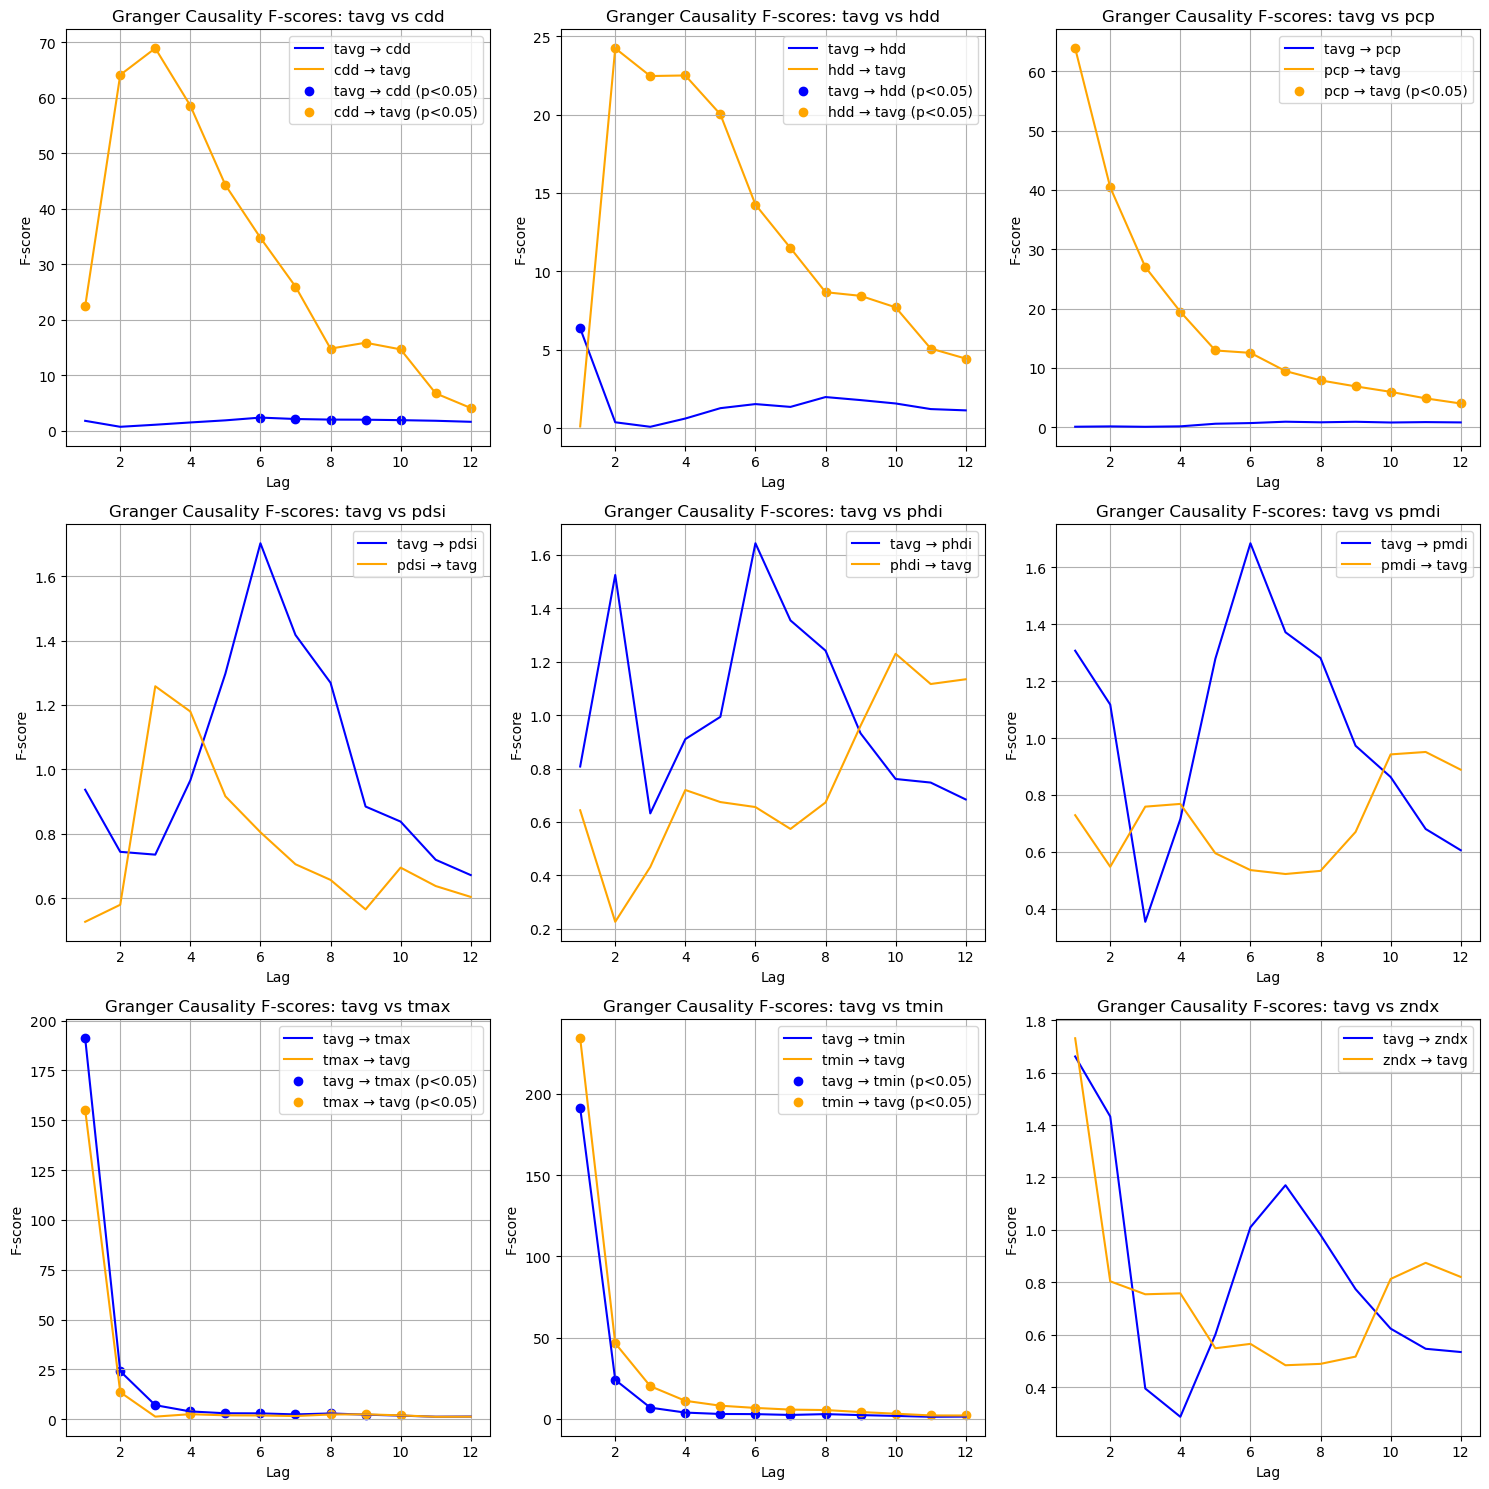

In [132]:
plot_multiple_granger_f_scores(weather, weather.columns, 'tavg', 12)

Looking at Michigan's data, we see that the precipitation has causal effect on temperature, but not the other way round.

### Seasonal Decomposition & Simultaneous Train-Test Split (Precipitation)

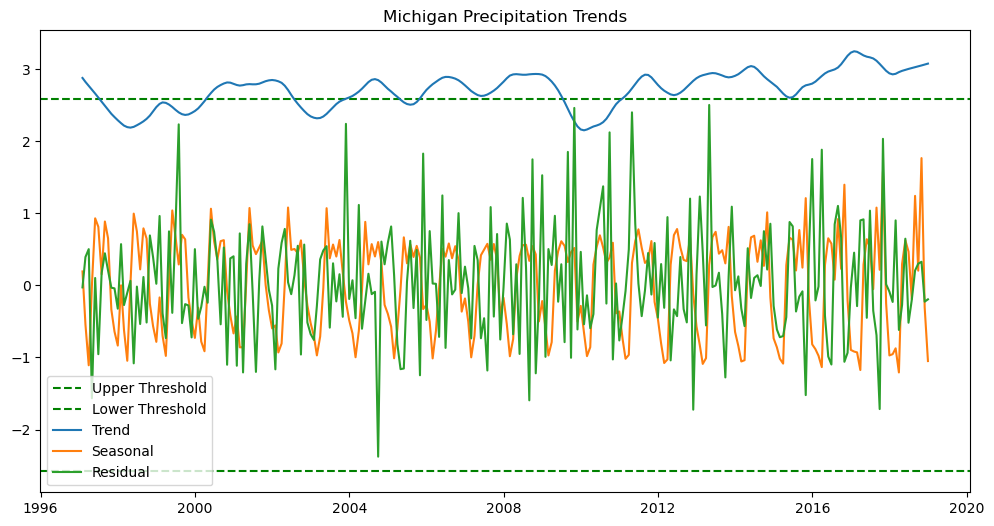

In [134]:
pcp_train, pcp_test, pcp_cleaned = seasonal_dc(weather, 'pcp', state)

### Auto-Correlation Check (Precipitation)

ADF p-value: 0.0034796551588345496


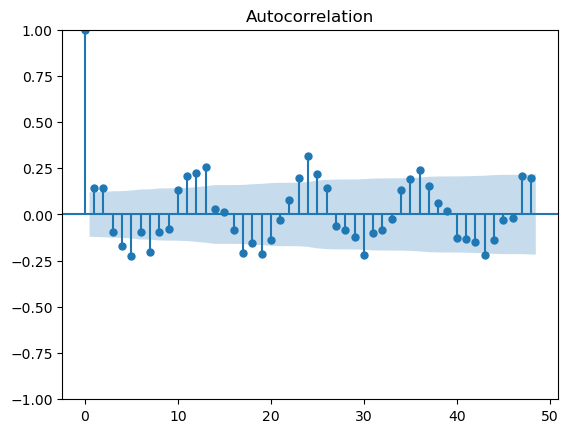

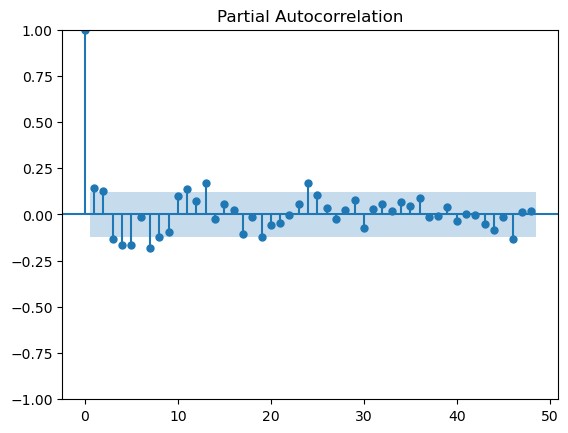

In [137]:
correlation_stats(pcp_train)

### Forecasting Weather (Precipitation)

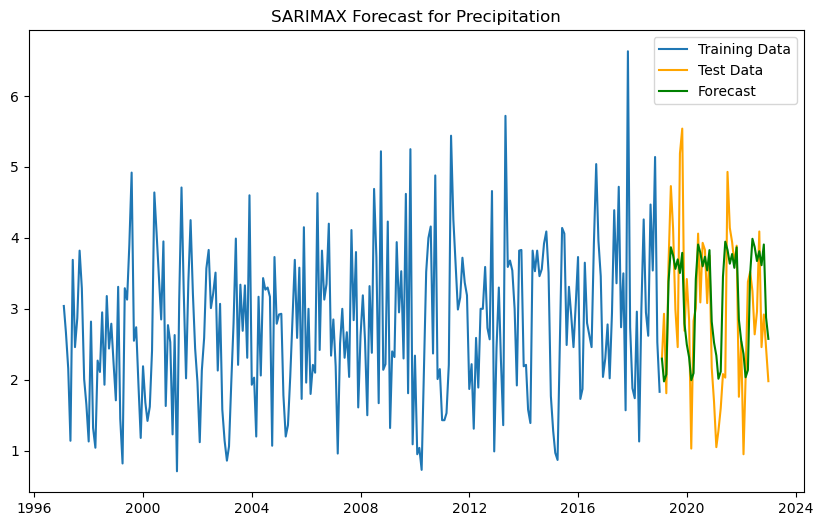

In [186]:
pcp_model, forecast_pcp = forecast_weather(pcp_cleaned, pcp_test, 'pcp')

The data is extremely noisy. Our main goal is to predict temperature, lets see if denoising or smoothening the pcp data is worth it. by assessing how well tavg is doing by itself

### Seasonal Decomposition of Temperature

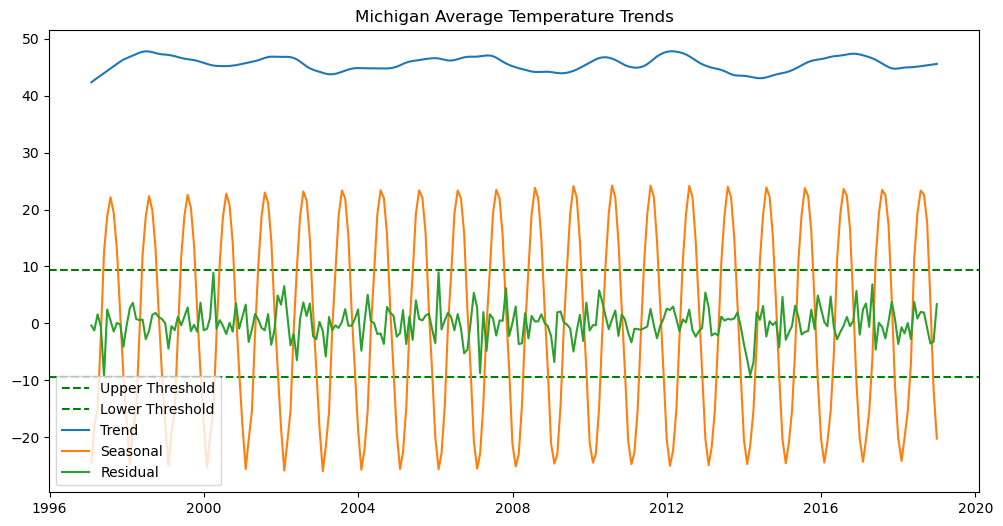

In [146]:
tavg_train, tavg_test, tavg_cleaned = seasonal_dc(weather, 'tavg', state)

### Auto-Correlation Check (Temperature)

ADF p-value: 0.014804212879941558


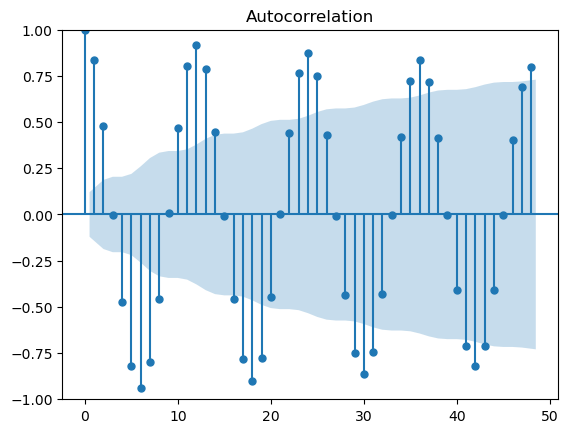

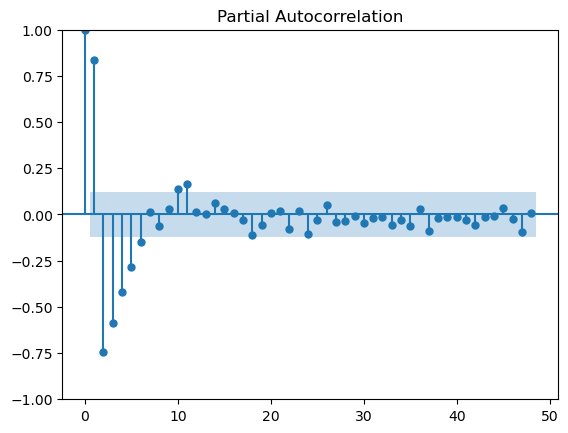

In [149]:
correlation_stats(tavg_cleaned)

### Forecasting Weather (Temperature)

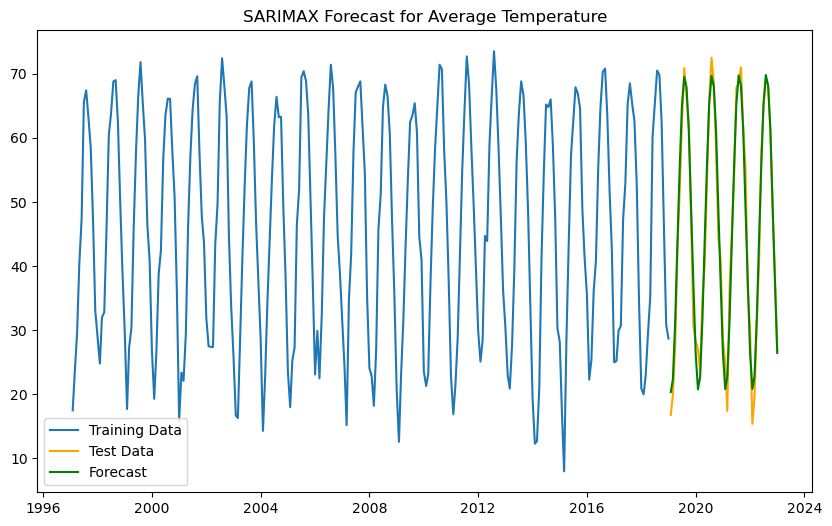

MAE: 2.4911201004003938
RMSE: 3.0426157148880026


In [233]:
tavg_model, forecast_tavg = forecast_weather(tavg_train, tavg_test, 'tavg', 48, 12, 2, 1, 2, 2, 1, 2)

We can see that the avg temp performs well by itself. The need for precipitation denoising is not high

In [223]:
forecast_tavg

2019-01-31    20.347347
2019-02-28    22.325768
2019-03-31    31.372082
2019-04-30    43.596232
2019-05-31    55.546837
                ...    
2024-08-31    68.195129
2024-09-30    61.348317
2024-10-31    49.040970
2024-11-30    37.658573
2024-12-31    26.478081
Freq: ME, Name: Forecast, Length: 72, dtype: float64